# Neighbors, Clusters, Classification

By [Allison Parrish](http://www.decontextualize.com/)

(Note: Rough draft! Notes incomplete. But very usable!)

In this notebook, I'm going to take you through a couple of simple, well-known techniques for exploring small sequences of text (like lines of poetry or sentences). These techniques include:

* Making vectors for text sequences
* Nearest-neighbor lookups for semantic similarity
* Visualizing corpora with t-SNE
* Clustering sentence vectors to discover similar items
* Classification with vectors

We're going to work with a corpus of several million lines of poetry, scraped from Project Gutenberg. Before you continue, download the file by executing the cell below:

In [1]:
!curl -L -O http://static.decontextualize.com/gutenberg-poetry-v001.ndjson.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52.2M  100 52.2M    0     0  1506k      0  0:00:35  0:00:35 --:--:--  989k7k      0  0:00:26  0:00:08  0:00:18 1571k


I'm going to use [spaCy](http://spacy.io/) extensively, both as a way to parse text into sentences and also as a source for pre-trained word vectors. Make sure you have it installed, along with the `en_core_web_md` or `en_core_web_lg` models. This notebook also assumes that you have [scikit-learn](https://scikit-learn.org/stable/), [numpy](https://numpy.org/) and [simpleneighbors](https://github.com/aparrish/simpleneighbors) installed.

## Sentence vectors

[Review the concept of word vectors](https://github.com/aparrish/rwet/blob/master/understanding-word-vectors.ipynb) before continuing.

Word vectors work great when we're interested in individual words. More often, though, we're interested in longer stretches of text, like sentences, lines, paragraphs. If we had a way to represent these longer stretches of text as vectors, we could perform all of the same operations on them that word vectors allow us to perform on words. But how to represent stretches of text as sequences?

There are lots of different ways! The classic technique in machine learning is to use the frequency of terms found in each sequence (methods like [tfidf](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/)), or similar techniques like [doc2vec](https://rare-technologies.com/doc2vec-tutorial/). Another way is to train a neural network (like an LSTM or transformer) for the task. There are any number of pre-trained models you can download and use for this, including Google's [Universal Sentence Encoder](https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html) and the [Sentence-Transformers](https://www.sbert.net/index.html) Python package.

But a surprisingly effective technique is to simply average together the word vectors for each word in the sentence. A big advantage of this technique is that *no further training is needed*, beyond the training needed to calculate the word vectors; if you're using pre-trained vectors, even that step can be skipped. You won't get state-of-the-art results on NLP benchmarks with this technique, but it's a good baseline and still useful for many tasks.

In the section below, I sample ten thousand lines of poetry from a Project Gutenberg poetry corpus and assign each a vector using this averaging technique.

In [2]:
import numpy as np
import spacy

In [3]:
import gzip, json, random

Load spacy's language model:

In [4]:
nlp = spacy.load('en_core_web_md')

And then load up all of the lines of poetry:

In [5]:
lines = []
for line in gzip.open("./gutenberg-poetry-v001.ndjson.gz"):
    data = json.loads(line)
    lines.append(data['s'])

In [6]:
len(lines)

3085117

To make things a bit faster and less memory-intensive, I'm only going to use ten thousand lines of poetry, sampled randomly. (You can change this number to something bigger if you want! But note that some of the stuff we're doing later on in the notebook will take longer.)

In [7]:
sampled_lines = random.sample(lines, 10000)

### Averages and weighted averages

Every spaCy span (i.e., documents, sentences, etc.) has a `.vector` attribute, which is calculated as the average of the vectors for each token in the span. The `summary()` function below parses the string you pass to it with spaCy and returns the vector that spaCy computes. (Here I disable the `parser`, `tagger` and `ner` [pipelines](https://spacy.io/usage/processing-pipelines) in order to make the process faster. We're just after the tokens and vectors—we don't need parts of speech, etc.)

In [10]:
def summary(sent):
    return nlp(sent, disable=['parser', 'tagger', 'ner', "lemmatizer"]).vector

The code in the cell below computes "summary vectors" for the lines of poetry sampled above:

In [11]:
embeddings = [summary(line) for line in sampled_lines]

And here's what they look like:

In [12]:
rand_idx = random.randrange(len(sampled_lines))
sampled_lines[rand_idx], embeddings[rand_idx]

('Sail away, ladies! Sail away!',
 array([ 1.79354623e-01,  1.39607385e-01,  1.13553759e-02, -3.66133749e-02,
         2.94853728e-02, -1.54177517e-01, -1.96891278e-03, -8.50000232e-03,
        -1.27148509e-01,  1.91346264e+00, -1.65987387e-03,  9.82288793e-02,
         1.76278487e-01,  1.39021218e-01, -2.14711249e-01, -2.28959784e-01,
        -1.09248504e-01,  9.89812493e-01, -2.37975009e-02,  5.81409968e-02,
         2.23507471e-02, -2.63815019e-02, -1.69122517e-02,  1.59805015e-01,
        -1.23718001e-01, -1.25438884e-01,  1.61229387e-01, -9.71438736e-02,
         1.24845542e-01,  2.50177532e-02,  2.38651261e-02,  2.91765004e-01,
        -5.44340312e-01,  5.08149266e-02,  6.87413737e-02, -1.22585997e-01,
         1.78992033e-01,  7.63377473e-02, -3.83257531e-02,  1.15164928e-01,
        -1.20486662e-01, -1.17931843e-01,  2.76412629e-03, -2.47587323e-01,
         2.70305008e-01,  1.91862136e-03, -5.49612604e-02, -1.07308373e-01,
         1.27030000e-01, -1.38395000e-02,  1.50517106e

## Build your own little search engine

Sentence vectors aren't especially interesting on their own! One thing we can use them for is to build a tiny "search engine" based on semantic similarity between lines. To do this, we need to be able to calculate the distance between a target sentence's vector (not necessarily a sentence from our corpus) and vectors of the sentences in the corpus, returning them ranked based on the distance between the two vectors. However, doing this comparison is computationally expensive and potentially very slow. Instead, we'll use an *approximate* nearest neighbors algorithm, which uses some tricks to make the computation faster, at the cost of a little bit of accuracy. I'm going to use the Simple Neighbors package as a way to build an approximate nearest neighbors index quickly and easily.

In [13]:
from simpleneighbors import SimpleNeighbors

In the cell below, I build a nearest-neighbor lookup for the sampled lines of poetry:

In [14]:
lookup = SimpleNeighbors(300)
for vec, line in zip(embeddings, sampled_lines):
    lookup.add_one(line, vec)
lookup.build()

The `.nearest()` method returns the sentences from the corpus whose vectors are closest to the vector you pass in. The code in the cell below uses the `summary()` function to return the sentences most similar to the sentence you type in. The number controls how many sentences should be returned.

In [15]:
lookup.nearest(summary("I don't want the words, I want the sound."), 5)

['I cannot hate you, for I loved you then.',
 "And how to do it I don't clearly see,",
 'Some things they did I will not tell.',
 'I cannot bear it! Oh, I cannot tell them.',
 'And what do I hear?']

To get neighbors for a random item in the corpus:

In [16]:
lookup.neighbors(random.choice(lookup.corpus))

['Straightway speeds the fiery charger,',
 'Upon your fiery horses,',
 'Scorching sun that shrivels and sears,',
 'Blazed battlement and pinnet high,',
 'Lifted his torch, and, bursting through the crowd,',
 'Called Waywassimo, the lightning,',
 'On each bright handle, bending o’er the brink,',
 'The sky and ocean blending, each on fire,',
 'The process.  Heat and cold, and wind and steam,',
 'And rumorous winds, that stir the silent eaves,',
 'The wound, an arrow kene,',
 'Smooth as the level plain, your swelling pride,']

## Visualize poem space in two dimensions

Another thing you can do with sentence vectors is *visualize* them. But the vectors are large (in our case, 300 dimensions), which doesn't have an obvious mapping to 2-dimensional space. Thankfully, there are a number of algorithms to *reduce* the dimensionality of vectors. We're going to use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ("t-distributed stochastic neighbor embedding"), but there are others to experiment with that might be just as good or better for your application (like [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA) or [UMAP](https://umap-learn.readthedocs.io/en/latest/)).

Note in the code below, I'm using an even smaller subset of the data. (That's what the `[:2000]` is doing—just using the first 2000 samples. This is because t-SNE is *slow*, as is drawing the results of a t-SNE).

In [17]:
!{"/Users/samheckle/Documents/school/spring\ 2022/env/bin/python3"} -m pip install scikit-learn

  Using cached scikit_learn-1.0.2-cp38-cp38-macosx_10_13_x86_64.whl (7.9 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [21]:
!{"/Users/samheckle/Documents/school/spring\ 2022/env/bin/python3"} -m pip install matplotlib

  Using cached matplotlib-3.5.1-cp38-cp38-macosx_10_9_x86_64.whl (7.3 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.7/930.7 KB 10.5 MB/s eta 0:00:00m eta 0:00:010:00:01


In [19]:
from sklearn.manifold import TSNE
mapped_embeddings = TSNE(n_components=2,
                         metric='cosine',
                         init='pca',
                         verbose=1).fit_transform(embeddings[:2000])

/Users/samheckle/Documents/school/spring 2022/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/samheckle/Documents/school/spring 2022/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.102853


/Users/samheckle/Documents/school/spring 2022/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.705368
[t-SNE] KL divergence after 1000 iterations: 2.367109


The following line draws a very large image with the results of the t-SNE. (You might want to right-click to save the image and then bring it up in an image viewer to see the details.)

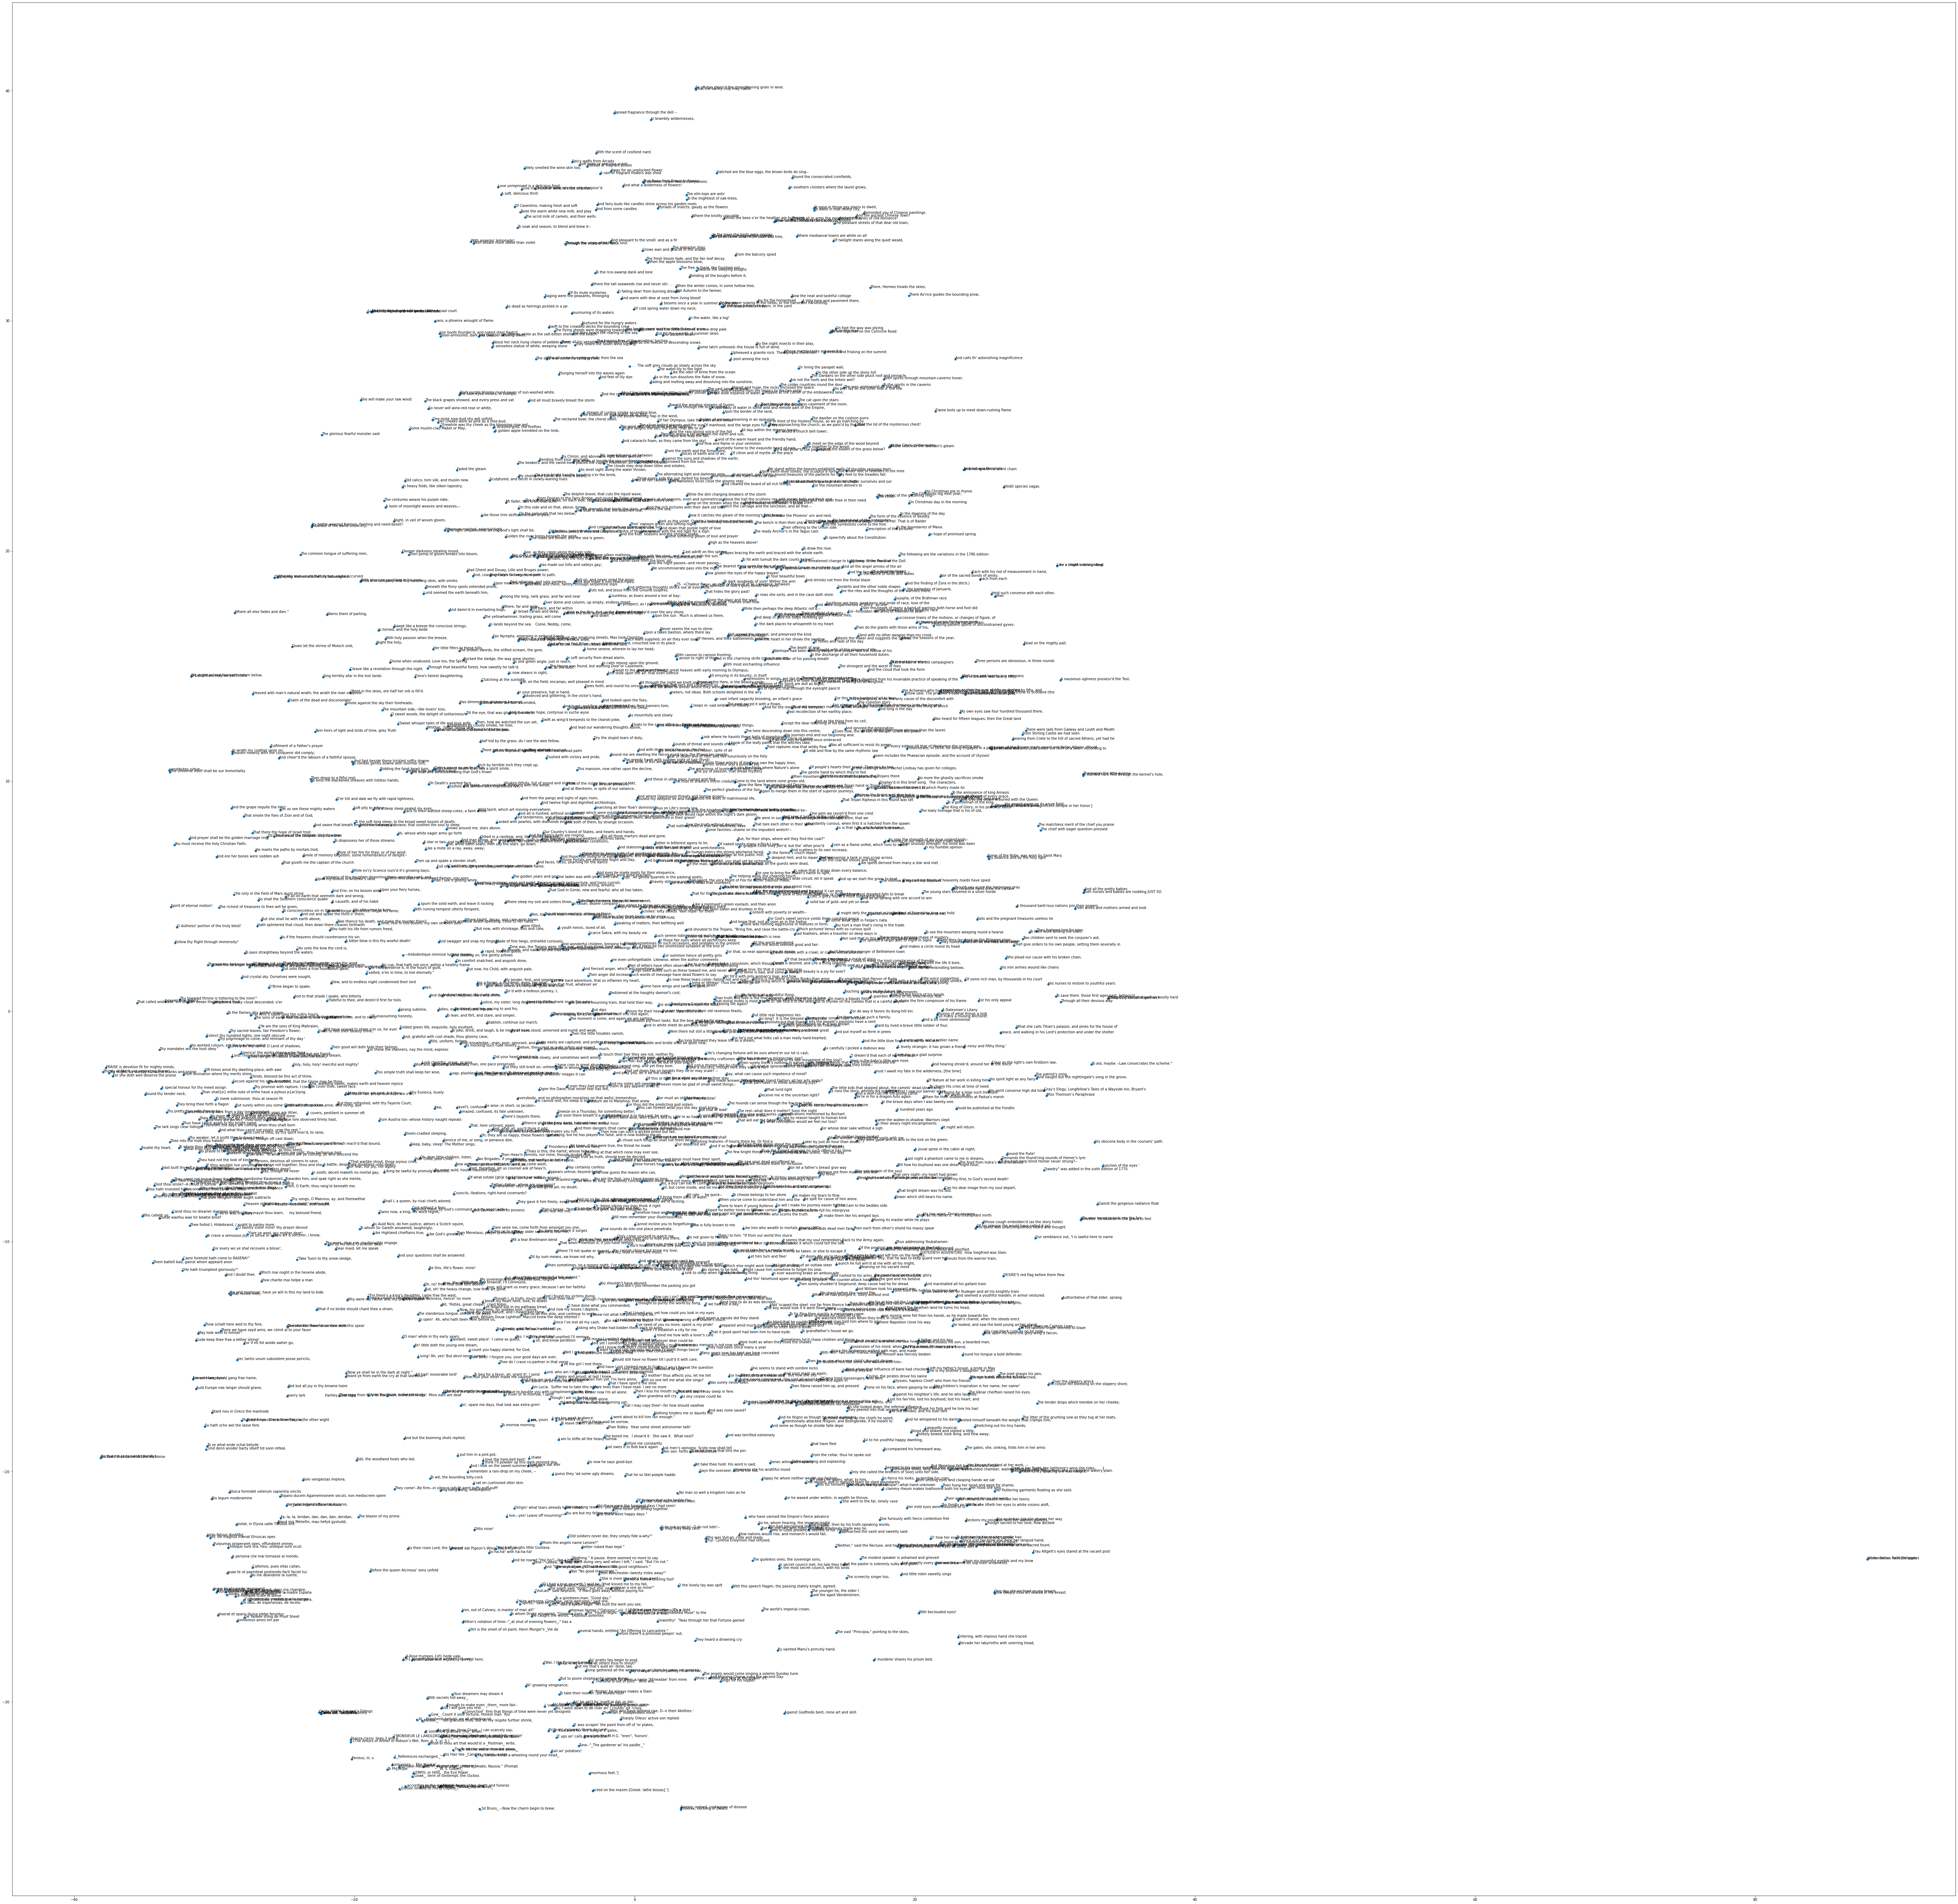

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(sampled_lines[:2000]):
    plt.annotate(txt, (x[i], y[i]))

### Exporting for Google Embedding Projector

[The Google Embedding Projector](https://projector.tensorflow.org/) is a handy web-based tool for exploring and visualizing data using different dimensional reduction techniques. The code in the following cells exports the data from our lines of poetry and embeddings in a format that you can upload to the tool:

In [20]:
with open("emb-proj-vecs.tsv", "w") as fh:
    for vec in embeddings[:2000]:
        fh.write("\t".join(["%0.5f" % val for val in vec]))
        fh.write("\n")

In [21]:
with open("emb-proj-labels.tsv", "w") as fh:
    fh.write("\n".join(sampled_lines[:2000]))

Click on the "Load" button in the interface, and upload the `emb-proj-vecs.tsv` file as "Vectors" and `emb-proj-labels.tsv` as "Metadata."

## Finding clusters

In the visualization above, you may have seen some evidence of "clustering"—groups of items that seem to be related. There are algorithms that facilitate finding such clusters *automatically*. This can be an interesting and valuable way to explore your data—you might find clusters of meaning that you didn't expect.

We're going to use the [K-Means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering) (in particular, scikit-learn's [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

In [22]:
cluster_count = 25 # adjust this until it starts giving you good results!

In [24]:
from sklearn.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=cluster_count)
clusters = clusterer.fit_predict(embeddings)

In [25]:
from collections import defaultdict
group_by_cluster = defaultdict(list)

In [26]:
for i, item in enumerate(clusters):
    group_by_cluster[item].append(sampled_lines[i])

In [28]:
for i in range(cluster_count):
    print(f"Cluster {i} ({len(group_by_cluster[i])} items)")
    print("Closest to center: ", lookup.nearest(clusterer.cluster_centers_[i], 1)[0])
    print()
    print("\n".join(random.sample(group_by_cluster[i],
                  min(8, len(group_by_cluster[i])))))
    print("\n---")

Cluster 0 (2 items)
Closest to center:  Out of old graves arose the cry of life;

Beneath whose shade the graves of heroes lie;
Out of old graves arose the cry of life;

---
Cluster 1 (665 items)
Closest to center:  scenery. The river Peneus ran through it, but not with the

And where within the surface of the river
With power to walk at will the ocean-floor,
Could Sicily more charming forests show
The crocus breaking earth;
The dreary road we all must tread,
Is pumped up brisk now, through the main ventricle,
While the waters murmur tranquilly
The sunlight leaves behind,

---
Cluster 2 (352 items)
Closest to center:  she fated to redeem one man of them from an evil doom. So

Curse their own soul.
Well deemed the little God his ancient sway was o'er.
And now a mighty shade of me shall go beneath the earth!
And from his holy lips these accents broke:
Like eternities of ice!
This caravan of life passes in curious guise! Be on thy
(On her soul may our Lady have gramercy!)
That human heart

## Classifying texts

Sentence vectors make it easy to classify texts—i.e., based on an existing labelled corpus, predict what category some new text will fall into. Let's build a simple classifier that tries to determine whether a given stretch of text is more like a line of poetry or more like a sentence from a recipe book. First, download the plaintext version of [this book](http://www.gutenberg.org/ebooks/26209) and put it in the same directory as this notebook. (You might go in and remove the Gutenberg boilerplate, but you don't have to.)

The following cell parses this text into sentences:

In [48]:
recipe_sents = [sent.text.strip() for sent in nlp(open("./pg26209.txt").read().replace("\n", " "),
                                          disable=['tagger', 'ner', 'morphologizer']).sents if len(sent.text.strip())>0]

In [49]:
len(recipe_sents)

2525

In [50]:
random.sample(recipe_sents, 10)

['Wash half a cup of rice, drain from the water.',
 'If you are redistributing or providing access to a work with the phrase "Project Gutenberg" associated with or appearing on the work, you must comply either with the requirements of paragraphs 1.E.1 through 1.E.7 or obtain permission for the use of the work and the Project Gutenberg-tm trademark as set forth in paragraphs 1.E.8 or 1.E.9.',
 'Sprinkle a pastry board thickly with flour, turn the mixture out from the bowl, cut off pieces of it and roll with the hands until about an inch and a half thick, cut in pieces about two inches long, the ends bias.',
 'Serve hot with fruit or wine sauce.',
 'Dried figs',
 'I trust that before   many months it may be obtainable here.',
 'HARD SAUCE.',
 'TOMATOES STUFFED WITH CHEESE.',
 'Vegetables.',
 'RICE AND FIG PUDDING  may be made according to the preceding recipe, steaming or stewing the figs a little and chopping slightly.']

We'll pick exactly as many lines from our poetry corpus as the number of sentences we found in the recipe book. (This is cheating a little bit, since most machine learning classification algorithms work best with "balanced classes.")

In [51]:
classify_poem_lines = random.sample(lines, len(recipe_sents))

A classifier tries to predict a category *y* based on some data *X*. The machine learning algorithm is essentially trying to approximate a function *y = f(X)* that most accurately gives the corresponding labels *y* for each value in *X*. Our *X* is going to be the sentence vector for each sentence, and our *y* is going to be 0 for poetry, 1 for recipe. (Category labels should always be integers; starting with 0 and counting up is best.)

In [52]:
X = [] # embeddings of lines
y = [] # categories of lines
all_text = [] # actual text

In [53]:
for text in classify_poem_lines:
    all_text.append(text)
    X.append(summary(text))
    y.append(0) # 0 for poem
for text in recipe_sents:
    all_text.append(text)
    X.append(summary(text))
    y.append(1) # 1 for recipes

In [54]:
X[100], y[100], all_text[100] # tuple = single, double, triple vs. n-gram = unigram, bigram, trigram) 

(array([ 1.05530716e-01,  1.29787847e-01, -1.80989996e-01,  1.77929565e-01,
         1.03046417e-01, -1.76728725e-01, -1.21441282e-01, -1.03238607e-02,
        -1.62457139e-03,  1.84444296e+00, -5.92244342e-02,  1.03079140e-01,
        -1.47599831e-01, -1.91853300e-01, -4.74735722e-02,  1.11312285e-01,
         4.90938537e-02,  9.31115687e-01, -2.02152848e-01,  5.24719991e-02,
        -2.18834858e-02,  4.64212857e-02,  4.35970016e-02,  8.48951489e-02,
         5.85387871e-02,  6.34502843e-02, -2.42500007e-02,  4.91591431e-02,
        -1.81718305e-01, -4.07582857e-02,  8.28629956e-02,  1.19827144e-01,
        -1.44335285e-01,  5.67120016e-02,  3.97439934e-02, -2.31866434e-01,
        -6.87589869e-02,  1.03116855e-01,  4.96844277e-02, -4.87052575e-02,
         2.50958595e-02,  4.56716341e-04,  2.40320005e-02, -1.53385714e-01,
        -2.65885773e-03, -6.82579819e-03, -2.62848586e-01, -2.03825429e-01,
         4.45191450e-02,  1.29101425e-02, -5.25691397e-02, -2.12071389e-02,
        -2.0

Validate that our categories are even:

In [55]:
from collections import Counter
Counter(y).most_common()

[(0, 2525), (1, 2525)]

Any classifier has a 50% chance of getting any guess correct. So for our classifier to be any good, it has to be able to predict with a greater than 50% chance.

### Train/test split

We'll train the model with some of our data, and set aside some of the data for testing the model. It's important to set aside testing data as a way to validate that the model is accurate on data that it has never seen. The `train_test_split()` function in scikit-learn is a very easy way to do this. It first shuffles the data, and then partitions it into two parts: training data (75%) and testing data (25%).

In [ ]:
# "overfitting" model learns the data exactly

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(np.array(X), np.array(y), all_text)

In [58]:
len(X_train), len(y_train), len(text_train), len(X_test), len(y_test), len(text_test)

(3787, 3787, 3787, 1263, 1263, 1263)

Now, we're training the classifier. We won't go into the details of how the classifier works! You could drop in any other classifier, really, including a neural network. But the Random Forest Classifier works just fine and is surprisingly fast.

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rfc = RandomForestClassifier(n_estimators=200, class_weight="balanced", verbose=1, n_jobs=-1)

In [61]:
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.1s finished


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       verbose=1)

Now, we'll see how accurate the model is by *predicting* the categories in the test set.

In [62]:
preds = rfc.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [64]:
from sklearn import metrics

The accuracy score is simply a percentage of how many predictions were correct:

In [65]:
metrics.accuracy_score(y_test, preds)

0.9738717339667459

But there are other useful measures of how good the model is at classifying things:

In [66]:
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       632
           1       0.99      0.96      0.97       631

    accuracy                           0.97      1263
   macro avg       0.97      0.97      0.97      1263
weighted avg       0.97      0.97      0.97      1263



* precision = of items labeled X, how many were actually X?
* recall = of all items that were actually X, how many were labeled X?
* f1 score: weighted average of the two.

Let's try classifying individual, randomly-selected items. (Remember, 0 is poem, 1 is recipe.)

In [67]:
rand_idx = random.randrange(len(X_test))
print(rfc.predict([X_test[rand_idx]]), text_test[rand_idx])

[1] Let it cook until clear, add the sugar and salt, and then the strawberry juice, and boil until thick--a few minutes only; turn into an earthenware mould; when cold set on the ice.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


The `.predict_proba()` method gives us the *probability* of each category, rather than just the category. The first item in the square brackets is the probability of category 0 (i.e., poem), and the second item is the probability of category 1 (i.e., recipe). The larger the number, the more probable the text belongs to that category (according to the classifier).

In [68]:
rand_idx = random.randrange(len(X_test))
print(rfc.predict_proba([X_test[rand_idx]]), text_test[rand_idx])

[[0.905 0.095]] They scuttle, or, in ghoulish greed,


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


Predicting everything in the test set along with probabilities:

In [69]:
preds_with_prob = rfc.predict_proba(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In the test set, here are the items deemed most likely to be poetry, along with their predicted probabilities and true category:

In [70]:
for idx in np.argsort(preds_with_prob[:,0])[-10:]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

Cramps his spirit, crowds its all in little, [0.99 0.01] 0
Waltz," and whirled on the pavement in time, till I doubt if she [0.99 0.01] 0
Her feelings have the fragrancy, [0.99 0.01] 0
And I kneel here for thy grace.' [0.99 0.01] 0
But her young eyes were all one moan, [0.99 0.01] 0
Bring us to thy Son's sight. [0.995 0.005] 0
Vpon the King Alanzon prest so sore, [0.995 0.005] 0
He turns from the worship of thee, as thou art, [0.995 0.005] 0
And heard thy voice upon the billowy blast; [0.995 0.005] 0
And amid the words of mercy, falling on my soul like balms, [0.995 0.005] 0


Likewise, those deemed most likely to be from the recipe book:

In [71]:
for idx in np.argsort(preds_with_prob[:,0])[:10]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

Put over the fire in a saucepan three-quarters of a cup of rich milk and three ounces of butter, let them come to a boil, then add three ounces of dried and sifted bread crumbs and an even tablespoonful of flour. [0. 1.] 1
Put the grated chocolate in a mixing bowl, break an egg into it and add one tablespoonful of bread crumbs and one of sugar, beat light and break another egg into it, adding another tablespoonful of bread crumbs and one of sugar. [0. 1.] 1
Half a pint of flour, half a pint of rich milk, a quarter of a teaspoonful of salt, three eggs beaten separately and very light. [0. 1.] 1
Cut off the tender green tips of asparagus about an inch and a half long, cover with boiling water and cook until tender. [0. 1.] 1
APPLE CUSTARD.--No. [0. 1.] 1
Make a sauce of two tablespoonfuls of butter and one tablespoonful of flour cooked together until smooth without browning. [0. 1.] 1
Season with salt, cayenne pepper to taste, and add a teaspoonful of grated onion and a saltspoonful of m

The most ambiguous items (i.e., the items whose probabilities are closest to 50% for each category):

In [72]:
diffs = np.abs(preds_with_prob[:,0] - preds_with_prob[:,1])

In [73]:
for idx in np.argsort(diffs)[:20]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

Do not let them remain in the water. [0.5 0.5] 1
Very refreshing in warm weather and an excellent remedy for oiliness of the skin. [0.5 0.5] 1
All sweet sounds together; [0.495 0.505] 0
Unless you have removed all references to Project Gutenberg:  1.E.1. [0.495 0.505] 1
Then pluck a reed [0.49 0.51] 0
It is better to make it the day before it is wanted. [0.51 0.49] 1
It keeps well. [0.51 0.49] 1
To SEND DONATIONS or determine the status of compliance for any particular state visit http://pglaf.org  While we cannot and do not solicit contributions from states where we have not met the solicitation requirements, we know of no prohibition against accepting unsolicited donations from donors in such states who approach us with offers to donate. [0.4762505 0.5237495] 1
]                                       THE                                 GOLDEN AGE                                 COOK BOOK. [0.475 0.525] 1
Apply with a soft linen cloth. [0.525 0.475] 1
This quantity will make fourteen 

Finally, lines of poetry deemed to be recipe-like:

In [74]:
recipelike = []
for idx in np.argsort(preds_with_prob[:,0]):
    if y_test[idx] == 0:
        recipelike.append((text_test[idx], preds_with_prob[idx]))
for item, score in recipelike[:12]:
    print(item, score)

And showed them eggs cooked a la Huguenot. [0.195 0.805]
Fell crushed to powder on the grass. [0.245 0.755]
Tactus aratro est;-- [0.27666725 0.72333275]
Pigeons dip their beaks to drink from the water. [0.415 0.585]
Then pluck a reed [0.49 0.51]
All sweet sounds together; [0.495 0.505]
How delicious is the winning [0.535 0.465]
Dandelion through the meadow makes [0.535 0.465]
hours: [0.54 0.46]
The author made almost no attempt to arrange the material [0.55 0.45]
He did not eat of the bridal bread, [0.565 0.435]
Was quick to understand. [0.565 0.435]


And poem-like recipe sentences:

In [75]:
poemlike = []
for idx in np.argsort(preds_with_prob[:,1]):
    if y_test[idx] == 1:
        poemlike.append((text_test[idx], preds_with_prob[idx]))
for item, score in poemlike[:12]:
    print(item, score)

Unto the dumb lips of the flock he lent      Sad, pleading words, showing how man, who prays      For mercy to the gods, is merciless,      Being as god to those; albeit all life      Is linked and kin, and what we slay have given      Meek tribute of their milk and wool, and set      Fast trust upon the hands which murder them." [0.925 0.075]
I send this little book out into the world, first, to aid those who, having decided to adopt a bloodless diet, are still asking how they can be nourished without flesh; second, in the hope of gaining something further to protect "the speechless ones" who, having come down through the centuries under "the dominion of man," have in their eyes the mute, appealing look of the helpless and oppressed. [0.825 0.175]
And to every beast of the earth, and to every fowl of the air, and to every thing that creepeth upon the earth, wherein there is life, I have given every green herb for meat: and it was so.--Genesis i., 29, 30. [0.825 0.175]
_And everyone wh

You can predict the category of an arbitrary sentence by first vectorizing it use the same method you used to vectorize the sentences in the model, then passing it to `.predict()`:

In [76]:
rfc.predict_proba([summary("Roses are red, violets are blue")])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


array([[0.68, 0.32]])

This tells us the model believes the sentence we gave it is a bit more likely to be poetry than a recipe. You can repeat this for an entire text! the following cell reads in the contents of a file line by line, calculates the vectors for those lines, and runs the prediction on them:

In [77]:
file_lines = [line.strip() for line in open("sonnets.txt").readlines() if len(line.strip()) > 0]
file_vecs = [summary(line) for line in file_lines]
file_probs = rfc.predict_proba(file_vecs)

FileNotFoundError: [Errno 2] No such file or directory: 'sonnets.txt'

And now we can sort the text according to its most recipe-like lines:

In [78]:
idx = np.argsort(file_probs[:,0])
for i in idx[:25]:
    print(file_probs[i], file_lines[i])

NameError: name 'file_probs' is not defined